### Brain Tumour Segmentation using Unet

Worldwide, incidences of brain tumours increases every year. Brain tumours are classified as benign (noncancerous tumours) and malignant (cancerous).Subclasses of brain tumours are primary and secondary tumours. Primary tumours start in the brain or Central Nervous Systems (CNS) whereas the secondary tumours spread from other body parts into the brain. Depends on the degree of abnormality of brain tissue, the tumours are type casted into four (1 to 4) grading levels. Tumours with 1 and 2 are low grades which are less dangerous. 3&4 grade tumours are high-grade tumours which are highly susceptible to cancer. Primary tumours have several types amongst 36.1 % all primary tumours are referred as meningioma that found near the top and outer curve of the brain. Meningioma is slowly growing noncancerous tumours that cause seizures and visual problems. Glioma is abnormal growth in glial cells presents around the neurons in the brain. Pituitary tumours grow in pituitary glands that affect body functions. Meningioma are iso-dense dura-based masses developed at the meninges of the three layers of protecting tissue of the brain and spinal cord, whose diagnosis depends on its anatomical location, shape and appearance of cells. Pituitary tumours are abnormal mass growth in cells around the surface of the pituitary gland that located at the base of skull.

For this work we have provided you the Meningioma tumor images along with its masks. 

Build a Unet based segmentation model to segment the tumor region.

Dataset link:
https://drive.google.com/drive/folders/11rbveSfeTsTMwHsXyPzLGTN5SDfhWcR9?usp=sharing

#### Import the required libraries


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from tensorflow.keras.utils import normalize

#### Load the images and masks in one folder and properly resize to same size (If required)

In [69]:
image_dir='C:\\Users\\Senthil\\Desktop\\Unet_dataset\\images_brain_tum\\'

mask_dir='C:\\Users\\Senthil\\Desktop\\Unet_dataset\\masks_brain_tum\\'

SIZE=128

img_dataset=[]
mask_dataset=[]

images=os.listdir(image_dir)

for i,image_name in enumerate(images):
    if (image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_dir+image_name,0)
        image=Image.fromarray(image)
        image=image.resize((SIZE,SIZE))
        img_dataset.append(np.array(image))
        #img_dataset.append(image)
        
        
masks=os.listdir(mask_dir)

for i,image_name in enumerate(masks):
    if (image_name.split('.')[1]=='jpg'):
        image=cv2.imread(mask_dir+image_name,0)
        image=cv2.resize(image,(SIZE,SIZE))
        (thresh, bwimage) = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) # make sure mask is binary image
        #bwimage=Image.fromarray(bwimage)
        #mask_dataset.append(np.array(bwimage))
        mask_dataset.append(bwimage)


In [72]:
img_dataset=np.array(img_dataset)
img_dataset=normalize(img_dataset)
img_dataset=np.expand_dims(img_dataset,3)

mask_dataset=np.array(mask_dataset)
mask_dataset=mask_dataset/255.
mask_dataset=np.expand_dims(mask_dataset,3)


In [73]:
print(img_dataset.shape)

print(mask_dataset.shape)

(705, 128, 128, 1)
(705, 128, 128, 1)


In [76]:
np.unique(mask_dataset[0,:,:,0]) # make sure mask is having only 0 and 1 for binary class

array([0., 1.])

#### Display some of the images along with its mask and make sure the position of mask matches with original image tumor position

In [77]:
r1=np.random.randint(1,705,size=(1,2))
r1[0][0],r1[0][1]

(96, 377)

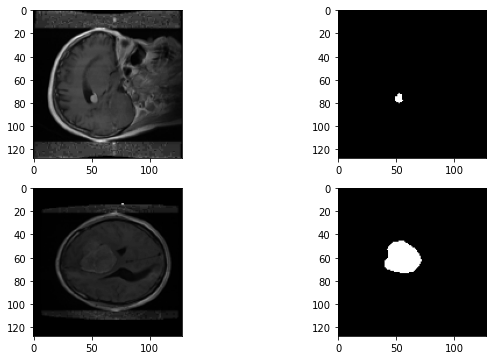

In [78]:
r1=np.random.randint(1,705,size=(1,2))
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(img_dataset[r1[0][0],:,:,:],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(mask_dataset[r1[0][0],:,:,:],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(img_dataset[r1[0][1],:,:,:],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(mask_dataset[r1[0][1],:,:,:],cmap='gray')

#### Write the function for Unet model. Properly define the ENCODER and DECODER section

In [79]:
# u-net model 
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#from tensorflow.keras import backend as K
from tensorflow.keras import backend as K


def simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    #c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    #c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    #c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    #c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    #c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    #c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    #c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    #c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])

    model.summary()
    
    return model
 

#### Define the Loss function and metric using Jecard coeff or dice coeff

In [80]:

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function



#### Split the data into train and test. Call the Unet model and metric/loss functions defined in previous questions and compile and fit the model

In [83]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(img_dataset,mask_dataset,test_size=0.15,random_state=0)


IMG_HEIGHT=img_dataset.shape[1]
IMG_WIDTH=img_dataset.shape[2]
IMG_CHANNELS=img_dataset.shape[3]

model=simple_unet_model_with_jacard(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

model.fit(x_train,y_train,batch_size=64,verbose=1,epochs=1,
          validation_data=(x_test,y_test),shuffle=False)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

#### Run with more iteration on Google colab for better result. As this segmentation process is tedius it will take lot iteration for convergence

#### Evaluate the model performance on the test data and predict the segmented output for random test image. Plot the original image, original mask and predicted mask.

106/106 [==============================] - 2s 18ms/sample - loss: -0.0246 - jacard_coef: 0.0238


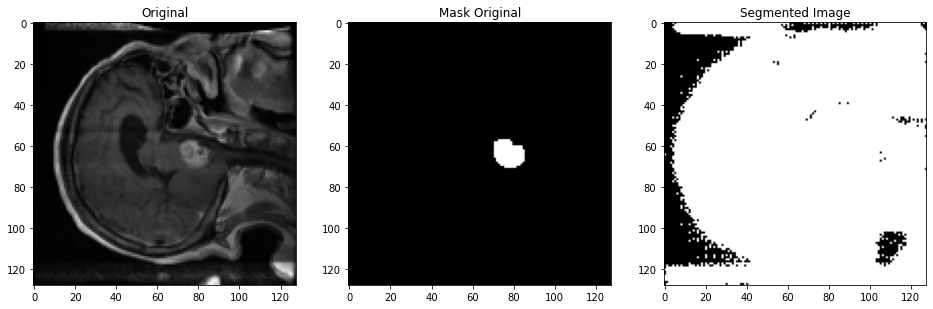

In [84]:

loss,jac_coef=model.evaluate(x_test,y_test)

n1=np.random.randint(0,len(x_test))
test_img=x_test[n1]
mask_test_img=y_test[n1]
test_img1=np.expand_dims(test_img,0)
pred_img=model.predict(test_img1)
pred_img1=(pred_img[0,:,:,0]>0.5).astype(np.uint8)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Original')
plt.imshow(test_img[:,:,0],cmap='gray')

plt.subplot(132)
plt.title('Mask Original')
plt.imshow(mask_test_img[:,:,0],cmap='gray')

plt.subplot(133)
plt.title('Segmented Image')
plt.imshow(pred_img1,cmap='gray')



#### Use some pretrained segmentation model from segmentation_model package to acheive the brain tumor segmentation task. 

In [85]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train_prepr = preprocess_input(x_train)
X_test_prepr = preprocess_input(x_test)


In [86]:
np.unique(y_train)

array([0., 1.])

In [96]:
model_resnet_backbone = sm.Unet(BACKBONE, input_shape=(128,128,1), encoder_weights=None, classes=1, activation='sigmoid')

In [97]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef]

In [98]:
model_resnet_backbone.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [99]:
print(model_resnet_backbone.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_102 (ZeroPadding (None, 134, 134, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   3136        zero_padding2d_102[0][0]         
____________________________________________________________________________________________

In [100]:
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=64, 
          epochs=1,
          validation_data=(X_test_prepr, y_test))

Train on 599 samples, validate on 106 samples
599/599 [==============================] - 187s 312ms/sample - loss: 0.3960 - accuracy: 0.9262 - jacard_coef: 0.0227 - val_loss: 1279.9531 - val_accuracy: 0.9089 - val_jacard_coef: 1.3191e-05
